Our aim is to perform object detection using Retinanet.

LabelImg tool is used to get annotations for images. So after annotation, the final folder will contain images and their respective annotation files(xml and txt).

Dataset used: Chess Dataset

Labels in Dataset: Pawn, Knight, Rook

### Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Environment Setup: Cloning github repository (Fizyr retinanet)

In [ ]:
# Download and install in Colab required packages
!git clone https://github.com/fizyr/keras-retinanet.git
% cd keras-retinanet/
!pip install .
!python setup.py build_ext --inplace

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 5893 (delta 3), reused 0 (delta 0), pack-reused 5885
Receiving objects: 100% (5893/5893), 13.41 MiB | 1.95 MiB/s, done.
Resolving deltas: 100% (3967/3967), done.
/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=170852 sha256=a832309e2316baa7aefa5a235763034a6e63bb50afdadff156239d0577f30228
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13346 sha256=59a3dba6151436293f7af94fd2f1dcba33795213a5fcd14a562f1eeae7d5a226
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-retinanet keras

### Importing necessary libraries

In [102]:
import os
import sys
import math
import glob
import argparse
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import urllib
import warnings
warnings.filterwarnings('ignore')
import time
import cv2
import matplotlib.pyplot as plt

### Setting input files (train and validation) locations and also setting output files location

After getting annotations, we will first split whole data into training and validation data (as we have less amount of data thus doing this manually) and then seperate xml, txt and image files.

In [ ]:
# setting file locations
# input files
train_data = '/content/drive/My Drive/Retinanet/data/train/'
test_data = '/content/drive/My Drive/Retinanet/data/validation/'

# output files
train_annotations = './annotations.csv'
val_annotations = './val_annotations.csv'
label_file = './classes.csv'

### Filtering out train and test image files for different image extensions

As dataset contains images of different extensions: "jpg", "jpeg", "png", "PNG", "JPG" , thus using glob to find filenames for images of all this extensions

In [ ]:
# filter out the train test image files for listed 5 different image extensions
train_image=[]
test_image=[]
fileExtensions = [ "jpg", "jpeg", "png", "PNG", "JPG" ]
for extension in fileExtensions:
  train_image.extend(glob.glob( '/content/drive/My Drive/Retinanet/data/train/*' + extension ))
  test_image.extend(glob.glob( '/content/drive/My Drive/Retinanet/data/validation/*' + extension ))

### Seperating text and XML files for train and validation data

In [ ]:
# Seperating text files
train_txt=glob.glob('/content/drive/My Drive/Retinanet/data/train/' + '/*.txt')
test_txt=glob.glob('/content/drive/My Drive/Retinanet/data/validation/' + '/*.txt')

In [ ]:
# Seperating XML files
train_xml=glob.glob('/content/drive/My Drive/Retinanet/data/train/' + '/*.xml')
test_xml=glob.glob('/content/drive/My Drive/Retinanet/data/validation/' + '/*.xml')

### Converting XML annotations to CSV format

Converting XML annotations to csv format and then reading this csv file as dataframe so that we can give dataframe to our model

As dataset contains images with different extensions:"jpg", "jpeg", "png", "PNG", "JPG" , thus generalizing below data loader code for every image extension

In [ ]:
# CONVERT the XML annotations to CSV format
def convert_annotation(train_data, test_data, image_id,img_extension,filename, classes, train=False):
    if train:
        in_file = open(train_data + '%s.xml' % image_id)
    else:
        in_file = open(test_data + '%s.xml' % image_id)
    out_file = open(filename, 'a')
    tree = ET.parse(in_file)
    root = tree.getroot()

    if root.iter('object') is not None:
  ￼      for obj in root.iter('object'):
            cls = obj.find('name').text
            if cls not in classes:
                continue
            cls_id = classes.index(cls)

            xmlbox = obj.find('bndbox')
            x1 = math.ceil(float(xmlbox.find('xmin').text))
            y1 = math.ceil(float(xmlbox.find('ymin').text))
            x2 = math.ceil(float(xmlbox.find('xmax').text))
            y2 = math.ceil(float(xmlbox.find('ymax').text))
            if x1 == x2 or y1 == y2:
                continue
            if train:
                out_file.write( 
                    f'{train_data + image_id+"."+img_extension},{x1},{y1},{x2},{y2},{cls}\n')
            else:
                out_file.write(
                    f'{test_data + image_id+"."+img_extension},{x1},{y1},{x2},{y2},{cls}\n')
    else:
        if train:
            out_file.write(f'{train_data + image_id+"."+img_extension},,,,,\n')
        else:
            out_file.write(f'{test_data + image_id+"."+img_extension},,,,,\n')

# define the classes for the model
labels = ['pawn','knight','rook']

# create new annotation files for  Train/validation
open(train_annotations, 'w')
open(val_annotations, 'w')

# generalized code for every image extension
train_ids=[train_image[i].split('.')[0].split('/')[-1] for i in range(len(train_image))]
train_extensions=[train_image[i].split('.')[-1] for i in range(len(train_image))]
for image_id in train_ids:
    ind=train_ids.index(image_id)
    convert_annotation(train_data, test_data, image_id,train_extensions[ind],train_annotations, labels, train=True)

val_ids=[test_image[i].split('.')[0].split('/')[-1] for i in range(len(test_image))]
test_extensions=[test_image[i].split('.')[-1] for i in range(len(test_image))]
for image_id in val_ids:
    ind=val_ids.index(image_id)
    convert_annotation(train_data, test_data, image_id,test_extensions[ind], val_annotations, labels)

# creating classes file listing all classes
with open(label_file, 'w') as f:
    for i, line in enumerate(labels):
        f.write('{},{}\n'.format(line, i))

print('DONE')

DONE


The above function will create 3 files:

classes.csv : contains 3 classes of chess dataset: pawn, knight, rook

annotations.csv : contains annotations for train data

val_annotations.csv : contains annotations for validation data

In [ ]:
# Length of training and testing dataset
print('Length of training dataset: ',len(train_ids))
print('Length of validation dataset: ',len(val_ids))

Length of training dataset:  198
Length of validation dataset:  50


### Creating dataframe with annotations and classes for training and validation data using XML

In [ ]:
dftrain=pd.read_csv('annotations.csv',header=None)
dftrain.columns=['image_name','x_min','y_min','x_max','y_max','Class']
dftest=pd.read_csv('val_annotations.csv',header=None)
dftest.columns=['image_name','x_min','y_min','x_max','y_max','Class']

Dataframe has seperate rows for every object present in image for e.g. if image contains 3 objects then dataframe will have 3 rows corresponding to that image

In [ ]:
dftrain.head()

,image_name,x_min,y_min,x_max,y_max,Class
0,/content/drive/My Drive/Retinanet/data/train/0...,152,272,664,1082,knight
1,/content/drive/My Drive/Retinanet/data/train/0...,148,51,452,655,knight
2,/content/drive/My Drive/Retinanet/data/train/0...,125,32,328,414,knight
3,/content/drive/My Drive/Retinanet/data/train/0...,33,4,669,1010,knight
4,/content/drive/My Drive/Retinanet/data/train/0...,101,79,341,584,knight


In [17]:
dftest.head()

,image_name,x_min,y_min,x_max,y_max,Class
0,/content/drive/My Drive/Retinanet/data/validat...,33,44,145,283,knight
1,/content/drive/My Drive/Retinanet/data/validat...,100,54,457,697,knight
2,/content/drive/My Drive/Retinanet/data/validat...,174,27,432,431,knight
3,/content/drive/My Drive/Retinanet/data/validat...,163,51,628,1010,pawn
4,/content/drive/My Drive/Retinanet/data/validat...,144,55,308,354,rook


In [ ]:
# total rows in train and validation dataframes
print('total train images',len(dftrain))
print('total test images',len(dftest))

total train images 515
total test images 136


### Downloading and loading pre-trained model weights (resnet-50)

Instead of training model with scratch, model is trained by using pre-trained model weights, for e.g. we are using resnet-50 architecture

In [ ]:
os.makedirs("snapshots",exist_ok=True)
os.makedirs("logs",exist_ok=True)

In [ ]:
pretrained_model = ("./snapshots/_pretrained_model.h5")
url = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(url,pretrained_model)

('./snapshots/_pretrained_model.h5',
 <http.client.HTTPMessage at 0x7f495d39a7b8>)

### Model Training

For training model we are using default parameters:

model backbone: resnet50

Transformations: random transformations

Batch size: 4

Step size: 600

Epochs: 25

Learning rate: 0.001

Optimizer: Adam

image-min-side: 500

image-max-side: 833

We are also using validation annotations in training so that mAP is calculated on validation data and we can evaluate our model easily.

Also commented Earlystopping code in train.py file of clonned github repository so that model can be trained for 25 epochs itherwise when loss is not getting decreased, then model training stopped.

In [ ]:
# Training model
!./keras_retinanet/bin/train.py --backbone='resnet50' --weights {pretrained_model} --random-transform --batch-size=4 --steps 600 --epochs 25 --image-min-side  500 --image-max-side 833 --lr 0.001 --weighted-average csv annotations.csv classes.csv --val-annotations val_annotations.csv

Using TensorFlow backend.
2020-07-30 08:09:46.633856: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Creating model, this may take a second...
2020-07-30 08:09:48.426857: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-07-30 08:09:48.460695: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-07-30 08:09:48.461300: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-07-30 08:09:48.461382: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-

Result:

Maximum map we get: 0.8408

Total loss: 0.5697

Regression loss: 0.5076

Classification loss: 0.0621

Best model saved: resnet50_csv_21.h5

### Evaluating model

Using the best model weights according to the epochs which shows good learning and using below command to get the model results on validation set.

In [21]:
# evaluate model
!./keras_retinanet/bin/evaluate.py --backbone='resnet50' --iou-threshold 0.50 --image-min-side=600 --image-max-side=1000 csv val_annotations.csv classes.csv snapshots/resnet50_csv_21.h5 --convert-model

Using TensorFlow backend.
2020-07-30 12:00:17.768930: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Loading model, this may take a second...
2020-07-30 12:00:19.454114: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-07-30 12:00:19.498729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-07-30 12:00:19.499309: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-07-30 12:00:19.499355: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-0

### Inference code

In [100]:
# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

#### Load RetinaNet model

loading model and converting to inference to perform object detection on test images

In [91]:
# defining model path
model_path1='/content/keras-retinanet/snapshots/resnet50_csv_21.h5'
print(model_path1)
# load retinanet model
model = models.load_model(model_path1, backbone_name='resnet50')
model = models.convert_model(model)

/content/keras-retinanet/snapshots/resnet50_csv_21.h5
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.3174

#### Inference code for test images

In [105]:
# load label to names mapping for visualization purposes
labels_to_names={0:'pawn',1:'knight',2:'rook'}

In [144]:
# Setting threshold value
threshold_value=0.5

In [134]:
# Function that will take image as an input and detect objects with classes
def img_inference(img_path): 
  # load image
  image = read_image_bgr(img_path)
 
  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
 
  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)
 
  # process image
  start = time.time()
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  print("processing time: ", time.time() - start)
  print()

  # correct for image scale
  boxes /= scale
  print('Labels with probabilties:')

  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < threshold_value:
      break
 
    color = label_color(label)

    b = box.astype(int)
    draw_box(draw, b, color=color)

    caption = "{} {:.1f}".format(labels_to_names[label], score)
    print('label:',labels_to_names[label],'-' 'score:', score)
    draw_caption(draw, b, caption)
  
  plt.figure(figsize=(10, 10))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()  

#### Detection on some test images

processing time:  0.16253376007080078

Labels with probabilties:
label: knight -score: 0.99694234
label: pawn -score: 0.9470345
label: rook -score: 0.92549163
label: pawn -score: 0.76463675


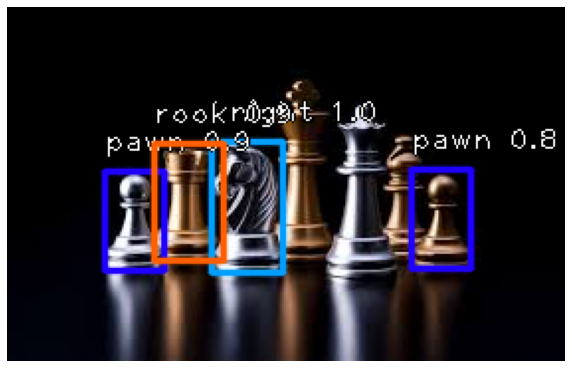

In [130]:
# Call the function
img_inference('/content/drive/My Drive/Retinanet/test7.jpeg')

processing time:  0.13265705108642578

Labels with probabilties:
label: pawn -score: 0.99083155
label: pawn -score: 0.9851281
label: knight -score: 0.98142576
label: knight -score: 0.9674649
label: rook -score: 0.9247178
label: rook -score: 0.8693042


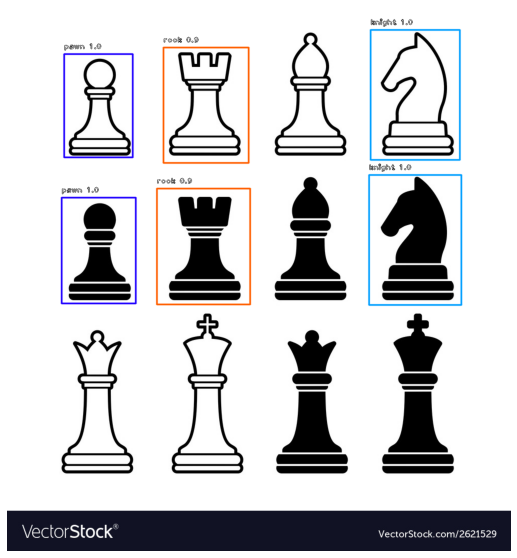

In [131]:
# Call the function
img_inference( '/content/drive/My Drive/Retinanet/test5.jpg')

processing time:  0.1286001205444336

Labels with probabilties:
label: knight -score: 0.9733088
label: rook -score: 0.96779877
label: knight -score: 0.965705
label: pawn -score: 0.9374837
label: rook -score: 0.93264043
label: pawn -score: 0.9178925
label: pawn -score: 0.91011554
label: pawn -score: 0.8982496
label: pawn -score: 0.8861929
label: pawn -score: 0.88331413
label: pawn -score: 0.83422035
label: pawn -score: 0.48275703


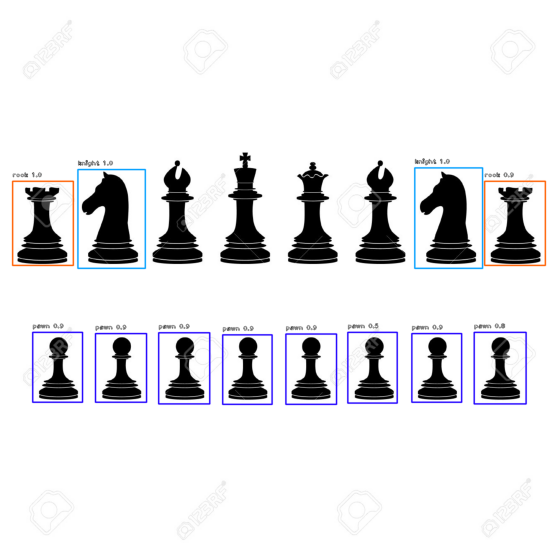

In [135]:
# Call the function
img_inference( '/content/drive/My Drive/Retinanet/test6.jpg')

processing time:  0.17033004760742188

Labels with probabilties:
label: pawn -score: 0.9783393
label: rook -score: 0.9146757
label: rook -score: 0.8953603
label: knight -score: 0.88699836


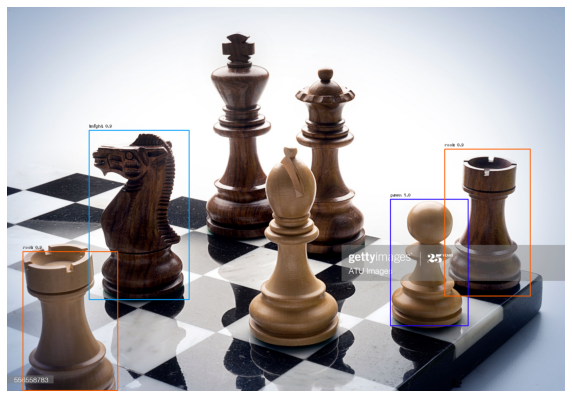

In [140]:
# Call the function
img_inference( '/content/drive/My Drive/Retinanet/test10.jpg')

processing time:  0.1469862461090088

Labels with probabilties:
label: pawn -score: 0.97403616
label: knight -score: 0.9722401
label: rook -score: 0.90767115


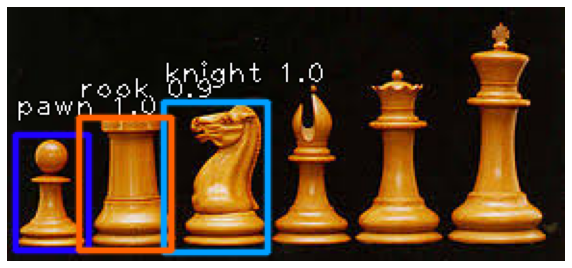

In [145]:
# Call the function
img_inference( '/content/drive/My Drive/Retinanet/test12.jpeg')